In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import random
from tqdm.notebook import tqdm

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Set random seed for reproducibility
SEED = 181
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
on_colab = False

In [ ]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    train_df = pd.read_csv('/content/drive/MyDrive/cs_data/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/cs_data/val.csv')
else: 
    train_df = pd.read_csv('data/train.csv')
    val_df = pd.read_csv('data/val.csv')
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train dataset shape: (19873, 3)
Validation dataset shape: (3039, 3)
Columns: ['time', 'snip', 'channel']

Sample training data:


,time,snip,channel
0,2024-01-01 00:00:00,"first of all, it feels like covid again but in...",FOXNEWSW
1,2024-01-01 00:03:00,to be a software drivenrganization where softw...,CSPAN
2,2024-01-01 00:15:00,you discuss the <b>power</b> <b>of</b> <em>ai<...,CSPAN2



Number of unique channels: 31

Class distribution in training set (top 10):


,count
channel,
CNNW,2725
FBC,1608
BBCNEWS,1576
BLOOMBERG,1441
CNBC,1319
MSNBCW,1141
FOXNEWSW,1106
CSPAN,913
CSPAN2,904


Class imbalance (max/min): 68.125


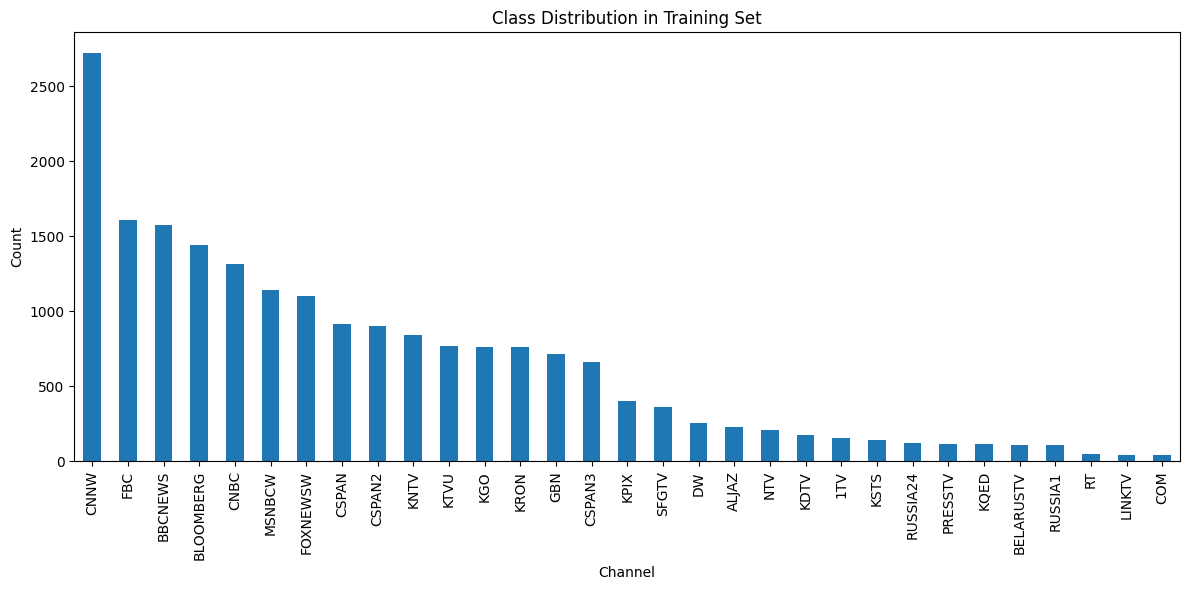


Sample text from CNNW:
<b>warning</b> <b>that</b> <em>ai</em> <b>will</b> <b>dramatically</b> alter the way the court operates.ng, quote, ai obviously has great potential to dramatically increase access to key information for lawyers and nonlawyers alike. just as obviously it risks invading privacy, interests and dehumani...


In [ ]:

# Display basic info
print(f"Train dataset shape: {train_df.shape}")
print(f"Validation dataset shape: {val_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

# Show a few samples from the sets
print("\nSample training data:")
display(train_df.head(3))

# Encode the labels consistently across datasets, important
label_encoder = LabelEncoder()
# Fit the encoder on all data to ensure consistent encoding
all_channels = pd.concat([
    train_df['channel'],
    val_df['channel']
]).unique()
label_encoder.fit(all_channels)

# Apply encoding to each split
train_df['label'] = label_encoder.transform(train_df['channel'])
val_df['label'] = label_encoder.transform(val_df['channel'])

print(f"\nNumber of unique channels: {len(all_channels)}")

# Analyze class distribution in the training set
train_class_counts = train_df['channel'].value_counts()
print(f"\nClass distribution in training set (top 10):")
display(train_class_counts.head(10))

# Check class imbalance
max_count = train_class_counts.max()
min_count = train_class_counts.min()
imbalance_ratio = max_count / min_count
print(f"Class imbalance (max/min): {imbalance_ratio}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
train_class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.ylabel('Count')
plt.xlabel('Channel')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Sample snippet from the most common channel
most_common_channel = train_class_counts.index[0]
sample_text = train_df[train_df['channel'] == most_common_channel]['snip'].iloc[0]
print(f"\nSample text from {most_common_channel}:")
print(sample_text[:300] + "..." if len(sample_text) > 300 else sample_text)


In [6]:
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

train_df = train_df.map(clean_html)
val_df = val_df.map(clean_html)


In [7]:
class Vocabulary:
    """Simple vocabulary class to convert words to indices"""

    def __init__(self, min_freq=2, max_size=50000):
        self.word2idx = {"<pad>": 0, "<unk>": 1}
        self.idx2word = {0: "<pad>", 1: "<unk>"}
        self.word_counts = {}
        self.min_freq = min_freq
        self.max_size = max_size

    def preprocess_text(self, text):
        # since we already cleaned tags above, we just lowercase and split
        if pd.isna(text):
            return []
        return text.lower().split()

    def build_vocab(self, texts):
        print("Building vocabulary...")

        # Count word frequencies
        for text in tqdm(texts):
            words = self.preprocess_text(text)

            for word in words:
                if word not in self.word_counts:
                    self.word_counts[word] = 0
                self.word_counts[word] += 1

        # Sort words by frequency in descending order
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)

        # Add words that meet minimum frequency to vocabulary
        idx = len(self.word2idx)
        for word, count in sorted_words:
            if count >= self.min_freq and idx < self.max_size:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary built with {len(self.word2idx)} words")
        print(f"Top 20 most frequent words:")
        for word, count in sorted_words[:20]:
            print(f"  {word}: {count}")

    def text_to_indices(self, text, max_length=None):
        words = self.preprocess_text(text)

        # Convert words to indices
        indices = []
        for word in words:
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx["<unk>"])

        # Truncate if needed
        if max_length is not None and len(indices) > max_length:
            indices = indices[:max_length]

        return indices

# Build vocabulary from the training data
vocab = Vocabulary(min_freq=2)
vocab.build_vocab(train_df['snip'].tolist())

# Test the vocabulary
sample_text = train_df['snip'].iloc[0]
sample_indices = vocab.text_to_indices(sample_text, max_length=100)
print(f"\nSample text: {sample_text[:100]}...")
print(f"Converted to indices: {sample_indices[:10]}...")
print(f"And back to words: {[vocab.idx2word[idx] for idx in sample_indices[:10]]}...")

Building vocabulary...


  0%|          | 0/19873 [00:00<?, ?it/s]

Vocabulary built with 50000 words
Top 20 most frequent words:
  the: 170647
  to: 101846
  and: 93838
  a: 80850
  of: 77478
  in: 58302
  is: 56650
  that: 48360
  you: 46175
  i: 37179
  for: 34898
  >>: 34275
  we: 33960
  it: 33309
  on: 30202
  with: 30185
  are: 27710
  this: 27178
  have: 21679
  ai: 21244

Sample text: first of all, it feels like covid again but instead of fact checking fauci, i need to fact check ai....
Converted to indices: [104, 6, 1396, 15, 1390, 42, 2572, 501, 25, 1114]...
And back to words: ['first', 'of', 'all,', 'it', 'feels', 'like', 'covid', 'again', 'but', 'instead']...


In [8]:
class TextDataset(Dataset):
    """Custom Dataset"""

    def __init__(self, texts, labels, vocab, max_length=200):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        indices = self.vocab.text_to_indices(text, self.max_length)

        # Make sure indices is not empty
        if len(indices) == 0:
            indices = [1]  # Use <unk> token if empty

        # Ensure label is an integer
        label = int(self.labels[idx])

        return {
            'text_indices': torch.tensor(indices, dtype=torch.long),
            'text_length': len(indices),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Create a small test dataset to verify everything works
test_dataset = TextDataset(
    texts=train_df['snip'].iloc[:5].tolist(),
    labels=train_df['label'].iloc[:5].tolist(),
    vocab=vocab
)

# Test one sample
sample = test_dataset[0]
print("Sample from dataset:")
print(f"Text indices shape: {sample['text_indices'].shape}")
print(f"Text length: {sample['text_length']}")
print(f"Label: {sample['label']}")


Sample from dataset:
Text indices shape: torch.Size([199])
Text length: 199
Label: 13


In [10]:
def collate_fn(batch):
    """Handle variable length sequences"""
    text_indices = [item['text_indices'] for item in batch]
    text_lengths = torch.tensor([item['text_length'] for item in batch], dtype=torch.long)
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)

    # Pad sequences
    padded_indices = pad_sequence(text_indices, batch_first=True)

    return {
        'text_indices': padded_indices,
        'text_lengths': text_lengths,
        'labels': labels
    }

def create_dataloaders(train_df, val_df, vocab, batch_size=32, use_sampler=True):
    """Create DataLoaders, with handling for class imbalance"""
    train_dataset = TextDataset(
        texts=train_df['snip'].tolist(),
        labels=train_df['label'].tolist(),
        vocab=vocab
    )

    val_dataset = TextDataset(
        texts=val_df['snip'].tolist(),
        labels=val_df['label'].tolist(),
        vocab=vocab
    )

    # Handle class imbalance with WeightedRandomSampler if need be
    if use_sampler:
        # Count samples per class
        class_counts = Counter(train_df['label'].tolist())

        # Calculate class weights (inverse frequency)
        total = len(train_df)
        class_weights = {class_id: total / count for class_id, count in class_counts.items()}

        # Assign weight to each sample
        sample_weights = [class_weights[label] for label in train_df['label'].tolist()]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # Create train dataloader with sampler
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=sampler,
            collate_fn=collate_fn
        )
    else:
        # Create regular train dataloader
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn
        )

    # val dataloader doesn't need to be weighted
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

    return train_dataloader, val_dataloader

# Create dataloaders
batch_size = 32
train_dataloader, val_dataloader = create_dataloaders(
    train_df, val_df, vocab, batch_size=batch_size, use_sampler=True
)

# Check the shape of a batch
for batch in train_dataloader:
    print(f"Batch shapes:")
    print(f"  Text indices: {batch['text_indices'].shape}")
    print(f"  Text lengths: {batch['text_lengths'].shape}")
    print(f"  Labels: {batch['labels'].shape}")
    break


Batch shapes:
  Text indices: torch.Size([32, 200])
  Text lengths: torch.Size([32])
  Labels: torch.Size([32])


### B1
* Now, we implement the feature representation of our choice -- learned representations! To do this, we will utilize an LSTM.

In [11]:
class LSTMTextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=256,
                 num_layers=2, bidirectional=True):
        """
        Args:
            vocab_size: Size of the vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Hidden dimension of LSTM
            num_layers: Number of LSTM layers
            bidirectional: Whether to use bidirectional LSTM
        """
        super(LSTMTextEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # First, map the vocabs to high dimensional embeddings

        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=num_layers,
                           batch_first=True,
                           bidirectional=bidirectional)

        # Save parameters to be able to remember them in the future for logging purposes
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_layers = num_layers

        # Representation dimension
        self.representation_dim = hidden_dim * 2 if bidirectional else hidden_dim

    def forward(self, text_indices, text_lengths):
        """
        Forward pass

        Args:
            text_indices: Tensor of shape [batch_size, seq_len]
            text_lengths: Tensor of shape [batch_size]

        Returns:
            representation: Tensor of shape [batch_size, representation_dim]
        """
        # Get batch size
        batch_size = text_indices.size(0)

        # Get embeddings
        embedded = self.embedding(text_indices)  # [batch_size, seq_len, embedding_dim]

        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # Pass through LSTM
        packed_output, (hidden, _) = self.lstm(packed_embedded)

        # Get representation from last hidden state
        if self.bidirectional:
            # For bidirectional, concatenate last hidden state from both directions
            # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
            hidden_forward = hidden[2*self.num_layers-2]  # [batch_size, hidden_dim]
            hidden_backward = hidden[2*self.num_layers-1]  # [batch_size, hidden_dim]
            last_hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch_size, hidden_dim * 2]
        else:
            # For unidirectional, just get the last layer's hidden state
            last_hidden = hidden[-1]  # [batch_size, hidden_dim]

        return last_hidden # which are the representations

Now we combine this with the actual classifier (this only learns the representations)

In [12]:
class B1Model(nn.Module):
    """Model that learns text representations and performs classification"""

    def __init__(self, vocab_size, num_classes, embedding_dim=300, hidden_dim=256,
                 num_layers=2, representation_dim=512, bidirectional=True):
        """
        Args:
            vocab_size: Size of the vocabulary
            num_classes: Number of classes for classification
            embedding_dim: Dimension of word embeddings
            hidden_dim: Hidden dimension of LSTM
            num_layers: Number of LSTM layers
            representation_dim: Final representation dimension (0 for no additional layer)
            bidirectional: Whether to use bidirectional LSTM
        """
        super(B1Model, self).__init__()

        # Text encoder (LSTM)
        self.encoder = LSTMTextEncoder(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional
        )

        encoder_output_dim = self.encoder.representation_dim

        # Representation layer (optional for dimensionality adjustment)
        if representation_dim > 0 and representation_dim != encoder_output_dim:
            self.representation_layer = nn.Sequential(
                nn.Linear(encoder_output_dim, representation_dim),
                nn.ReLU(),
            )
            self.final_representation_dim = representation_dim
        else:
            self.representation_layer = nn.Identity() # If the size is the same, just identity
            self.final_representation_dim = encoder_output_dim

        # Classification head
        self.classifier = nn.Linear(self.final_representation_dim, num_classes)

    def forward(self, text_indices, text_lengths):
        """
        Args:
            text_indices: Tensor of shape [batch_size, seq_len]
            text_lengths: Tensor of shape [batch_size]

        Returns:
            logits: Tensor of shape [batch_size, num_classes]
            representation: Tensor of shape [batch_size, final_representation_dim]
        """
        # Get encoder output
        encoder_output = self.encoder(text_indices, text_lengths)

        # Get representation
        representation = self.representation_layer(encoder_output)

        # Get classification logits
        logits = self.classifier(representation)

        return logits, representation

    def get_representation(self, text_indices, text_lengths):
        """Extract only the learned representation without classification"""
        with torch.no_grad():
            encoder_output = self.encoder(text_indices, text_lengths)
            representation = self.representation_layer(encoder_output)
        return representation

# Initialize the model
num_classes = len(label_encoder.classes_)
embedding_dim = 300
hidden_dim = 256
representation_dim = 512  # Can be adjusted
num_layers = 2
bidirectional = True

model = B1Model(
    vocab_size=len(vocab.word2idx),
    num_classes=num_classes,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    representation_dim=representation_dim,
    bidirectional=bidirectional
)

model = model.to(device)
print(model)

B1Model(
  (encoder): LSTMTextEncoder(
    (embedding): Embedding(50000, 300, padding_idx=0)
    (lstm): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  )
  (representation_layer): Identity()
  (classifier): Linear(in_features=512, out_features=31, bias=True)
)


Now, we train the model

In [16]:
def train_model(model, train_dataloader, val_dataloader, device,
                num_epochs=50, learning_rate=0.001, class_weights=None):
    """
    Train the representation learning model

    Args:
        model: The model to train
        train_dataloader: DataLoader for training data
        val_dataloader: DataLoader for validation data
        device: Device to train on
        num_epochs: Number of epochs to train for
        learning_rate: Learning rate
        class_weights: Weights for classes to handle imbalance

    Returns:
        trained_model: The trained model
        history: Dictionary with training history
    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Define loss function with class weights if provided
    if class_weights is not None:
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    # Track metrics for later
    best_val_accuracy = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            text_indices = batch['text_indices'].to(device)
            text_lengths = batch['text_lengths'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            logits, _ = model(text_indices, text_lengths)

            loss = criterion(logits, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                text_indices = batch['text_indices'].to(device)
                text_lengths = batch['text_lengths'].to(device)
                labels = batch['labels'].to(device)

                logits, _ = model(text_indices, text_lengths)

                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_dataloader)
        history['val_loss'].append(avg_val_loss)

        # Calculate F1 score (macro)
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        history['val_f1'].append(val_f1)

        # Calculate accuracy
        val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"Val F1 (macro): {val_f1:.4f}")

        # Save best model based on accuracy (since that's what we're optimizing for, per the pdf)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_representation_model.pt')
            print(f"Model saved with Accuracy: {val_accuracy:.4f}")

    # Load best model
    model.load_state_dict(torch.load('best_representation_model.pt'))

    return model, history

# Calculate class weights for loss function
class_counts = train_df['label'].value_counts().sort_index()
class_weights = (1.0 / class_counts) * (len(train_df) / len(class_counts))
class_weights = class_weights.values

print("Class weights preview (first 5):")
for i, weight in enumerate(class_weights[:5]):
    channel = label_encoder.inverse_transform([i])[0]
    print(f"  {channel}: {weight:.4f}")


Class weights preview (first 5):
  1TV: 4.0574
  ALJAZ: 2.7872
  BBCNEWS: 0.9655
  BELARUSTV: 2.5339
  BLOOMBERG: 0.3987


In [ ]:
num_epochs = 20
learning_rate = 0.001

print("Starting training...")
model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    class_weights=class_weights
)

# plots

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1')
plt.title('F1 Score (Macro)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

Starting training...


Epoch 1/20 - Training:   0%|          | 0/622 [00:00<?, ?it/s]